# CMO assignment


In this tutorial, we'll be walking through the steps to assignment of identity barcodes for multiple indexing experiments.

In this experiment, A549 lung carcinoma cells were transduced with a pool containing 93 total sgRNAs (90 sgRNAs targeting 45 different genes and 3 control sgRNAs). Cells were split into 6 conditions, receiving no treatment or treatments of DZNep, Trichostatin A, Valproic Acid, Kinetin, or, Resveratrol. Before sequencing, cells were multiplexed at equal proportions with 1 CMO per sample type. The original dataset is downloaded from 10x genomics [dataset](https://www.10xgenomics.com/resources/datasets/30-k-a-549-lung-carcinoma-cells-treatments-transduced-with-a-crispr-pool-multiplexed-6-cm-os-3-1-standard-6-0-0).

<div class="alert alert-info">

Note

To run this notebook on your device, you need to install [![scAR](https://img.shields.io/badge/install-scar-brightgreen)](https://scar-tutorials.readthedocs.io/en/latest/Installation.html). 

Alternatively, you can also run this notebook on Colab [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Novartis/scAR/blob/main/docs/tutorials/scAR_tutorial_identity_barcode.ipynb)

</div>

In [ ]:
# Run this cell to install scar in Colab
# Skip this cell if running on your own device

%pip install scanpy
%pip install git+https://github.com/Novartis/scAR.git
%pip install matplotlib==3.1.3  # Specify this matplotlib version to avoid errors

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
from scar import model

import warnings
warnings.simplefilter("ignore")

## Download data

The raw count matrices (cellranger output: raw_feature_bc_matrix) can be downloaded from 10x Dataset. Filtered count matrices are not available for this experiment.

In [2]:
A549_30K = sc.read_10x_h5(filename='CRISPR_A549_30K_Multiplex_count_raw_feature_bc_matrix.h5ad',
                          gex_only=False,
                          backup_url='https://cf.10xgenomics.com/samples/cell-exp/6.0.0/SC3_v3_NextGem_DI_CellPlex_CRISPR_A549_30K_Multiplex/SC3_v3_NextGem_DI_CellPlex_CRISPR_A549_30K_Multiplex_count_raw_feature_bc_matrix.h5');

A549_30K.var_names_make_unique();

Raw Count matrix of cell tags (unfiltered droplets)

In [3]:
A549_30K_CMO_raw = A549_30K[:, A549_30K.var['feature_types']=='Multiplexing Capture'].to_df()

## Estimate ambient profile

Identify cell-containing and cell-free droplets using kneeplot of mRNA counts.  

<div class="alert alert-info">

Note

An alternative is to calculate ambient profile with `setup_anndata` method. See an example in [calculating ambient profile](https://scar-tutorials.readthedocs.io/en/latest/tutorials/scAR_tutorial_ambient_profile.html).

</div>

In [4]:
all_droplets = pd.DataFrame(A549_30K[:,A549_30K.var['feature_types']=='Gene Expression'].X.sum(axis=1), index = A549_30K.obs_names, columns=['total_counts'])

all_droplets['droplets'] = 'cell-free droplets'
all_droplets['droplets'] = all_droplets['droplets'].mask(all_droplets['total_counts']>200, 'others')
all_droplets['droplets'] = all_droplets['droplets'].mask(all_droplets['total_counts']>500, 'cells')
all_droplets = all_droplets.sort_values(by='total_counts', ascending=False).reset_index().rename_axis("rank").reset_index()
all_droplets = all_droplets.loc[all_droplets['total_counts']>0]
all_droplets = all_droplets.set_index('index').rename_axis('cells')

The thresholds (200 and 500) are experiment-specific. We here manually determine them by examing the following kneeplot.

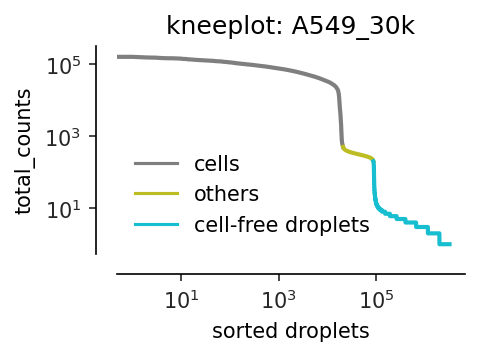

In [5]:
plt.figure(figsize=(3, 1.8), dpi=150)

ax = sns.lineplot(
    data = all_droplets,
    x='rank',
    y='total_counts',
    hue='droplets',
    hue_order=['cells', 'others', 'cell-free droplets'],
    palette=sns.color_palette()[-3:],
    markers=False,
    lw=2,
    ci=None
)

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('sorted droplets')
ax.legend(loc='lower left', ncol=1, title=None, frameon=False)
ax.set_title(f'kneeplot: A549_30k')

sns.set_palette("muted")
sns.set_style("ticks")
sns.despine(offset=10, trim=False);

**Raw count matrix of cell tags (filtered droplets)**

In [6]:
A549_30K_filtered = A549_30K[A549_30K.obs_names.isin(all_droplets[all_droplets['droplets']=='cells'].index)] # equal to filtered population as cellranger output

A549_30K_CMO_filtered = A549_30K_filtered[:, A549_30K_filtered.var['feature_types']=='Multiplexing Capture'].to_df() # pandas.DataFrame

A549_30K_CMO_filtered.head()

,CMO301,CMO302,CMO303,CMO304,CMO305,CMO306,CMO307,CMO308,CMO309,CMO310,CMO311,CMO312
AAACCCAAGCTAAGTA-1,0.0,0.0,0.0,0.0,1.0,0.0,30.0,3209.0,496.0,733.0,65.0,64.0
AAACCCAAGGAAGTGA-1,1.0,0.0,0.0,0.0,0.0,0.0,299.0,501.0,23515.0,710.0,469.0,895.0
AAACCCAAGGTTGGAC-1,0.0,1.0,0.0,0.0,0.0,0.0,129.0,192.0,28536.0,185.0,148.0,215.0
AAACCCAAGTGCGTCC-1,0.0,1.0,1.0,0.0,0.0,0.0,488.0,780.0,950.0,24423.0,783.0,1366.0
AAACCCAAGTGCTCGC-1,0.0,0.0,0.0,0.0,1.0,1.0,81.0,141.0,7604.0,158.0,99.0,204.0


**Ambient profile of cell tags (CMOs)**

In [7]:
cell_free_CMO = A549_30K_CMO_raw.loc[A549_30K_CMO_raw.index.difference(A549_30K_CMO_filtered.index)]
ambient_profile_CMO = cell_free_CMO.sum()/cell_free_CMO.sum().sum() # pandas.Series
ambient_profile_CMO = ambient_profile_CMO.to_frame("ambient profile")

ambient_profile_CMO.head()

,ambient profile
CMO301,0.000005
CMO302,0.000012
CMO303,0.000021
CMO304,0.000006
CMO305,0.000034


## Training

In [8]:
CMO = model(raw_count = A549_30K_CMO_filtered,
            ambient_profile=ambient_profile_CMO, # In the case of default None, the ambient_profile will be calculated by averaging pooled cells
            feature_type='tag' # We use the 'tag' for cell tag/cell indexing experiments
           )

CMO.train(epochs=80,
          batch_size=64,
          verbose=True,
         )

# After training, we can infer the native true signal
CMO.inference(cutoff=3)  # by defaut, batch_size=None, set a batch_size if getting a GPU memory issue

2023-05-01 19:09:45|INFO|model|No GPU detected. Use CPU instead.
2023-05-01 19:09:45|INFO|VAE|Running VAE using the following param set:
2023-05-01 19:09:45|INFO|VAE|...denoised count type: tag
2023-05-01 19:09:45|INFO|VAE|...count model: binomial
2023-05-01 19:09:45|INFO|VAE|...num_input_feature: 12
2023-05-01 19:09:45|INFO|VAE|...NN_layer1: 150
2023-05-01 19:09:45|INFO|VAE|...NN_layer2: 100
2023-05-01 19:09:45|INFO|VAE|...latent_space: 15
2023-05-01 19:09:45|INFO|VAE|...dropout_prob: 0.00
2023-05-01 19:09:45|INFO|VAE|...expected data sparsity: 1.00
2023-05-01 19:09:45|INFO|model|kld_weight: 1.00e-05
2023-05-01 19:09:45|INFO|model|learning rate: 1.00e-03
2023-05-01 19:09:45|INFO|model|lr_step_size: 5
2023-05-01 19:09:45|INFO|model|lr_gamma: 0.97


Training: 100%|██████████| 80/80 [02:12<00:00,  1.65s/it, Loss=1.2405e+02]


Resulting assignment is saved in `CMO.feature_assignment`.  

If there are multiple guides detected after denoising, try to increase the cutoff and re-run `CMO.inference(cutoff=10)`

Download metadata of CMOs and treatments

In [9]:
!wget https://cf.10xgenomics.com/samples/cell-exp/6.0.0/SC3_v3_NextGem_DI_CellPlex_CRISPR_A549_30K_Multiplex/SC3_v3_NextGem_DI_CellPlex_CRISPR_A549_30K_Multiplex_config.csv

metadata = pd.read_csv('SC3_v3_NextGem_DI_CellPlex_CRISPR_A549_30K_Multiplex_config.csv', sep='delimiter')

CMO2Tret = dict()
for val in metadata.iloc[11:].values:
    array_txt = val[0].split(",")
    CMO2Tret.update({array_txt[1]: array_txt[2].split("v2_")[-1]})
    
CMO2Tret

--2023-05-01 19:12:08--  https://cf.10xgenomics.com/samples/cell-exp/6.0.0/SC3_v3_NextGem_DI_CellPlex_CRISPR_A549_30K_Multiplex/SC3_v3_NextGem_DI_CellPlex_CRISPR_A549_30K_Multiplex_config.csv
Resolving cf.10xgenomics.com (cf.10xgenomics.com)... 104.18.0.173, 104.18.1.173, 2606:4700::6812:1ad, ...
Connecting to cf.10xgenomics.com (cf.10xgenomics.com)|104.18.0.173|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1360 (1.3K) [text/csv]
Saving to: ‘SC3_v3_NextGem_DI_CellPlex_CRISPR_A549_30K_Multiplex_config.csv.4’

100%[======================================>] 1,360       --.-K/s   in 0s      

2023-05-01 19:12:08 (32.3 MB/s) - ‘SC3_v3_NextGem_DI_CellPlex_CRISPR_A549_30K_Multiplex_config.csv.4’ saved [1360/1360]



{'CMO307': 'No_Treatment',
 'CMO308': 'DZNep',
 'CMO309': 'Trichostatin_A',
 'CMO310': 'Valproic_Acid',
 'CMO311': 'Kinetin',
 'CMO312': 'Resveratrol'}

In [10]:
CMO.feature_assignment['treatment'] = CMO.feature_assignment['tag'].map(CMO2Tret)

CMO.feature_assignment.head()

,tag,n_tag,treatment
AAACCCAAGCTAAGTA-1,CMO308,1,DZNep
AAACCCAAGGAAGTGA-1,CMO309,1,Trichostatin_A
AAACCCAAGGTTGGAC-1,CMO309,1,Trichostatin_A
AAACCCAAGTGCGTCC-1,CMO310,1,Valproic_Acid
AAACCCAAGTGCTCGC-1,CMO309,1,Trichostatin_A


## Visulization

### Cell clustering

We can cluster the cells and visulize them with UMAP. 

In [11]:
A549_30K_filtered.obs = A549_30K_filtered.obs.join(CMO.feature_assignment, how='left')

A549_30K_mRNA_filtered = A549_30K_filtered[:, A549_30K_filtered.var['feature_types']=='Gene Expression']

In [12]:
random_state = 8
adata_out = A549_30K_mRNA_filtered.copy()
sc.pp.filter_genes(adata_out, min_cells=20)
sc.pp.filter_cells(adata_out, min_genes=200)
sc.pp.normalize_total(adata_out, target_sum=1e4)
sc.pp.log1p(adata_out)

sc.tl.pca(adata_out, svd_solver='arpack', random_state=random_state)
sc.pp.neighbors(adata_out, n_neighbors=15, n_pcs=25, random_state=random_state)

sc.tl.umap(adata_out, random_state=random_state)

Let's filter out the cells with multiple CMOs

In [13]:
adata_out = adata_out[adata_out.obs['n_tag']==1]

print("{:.2f}% cells are assigned with a single CMO".format(adata_out.shape[0]/A549_30K_mRNA_filtered.shape[0]* 100))

87.82% cells are assigned with a single CMO


### UMAP

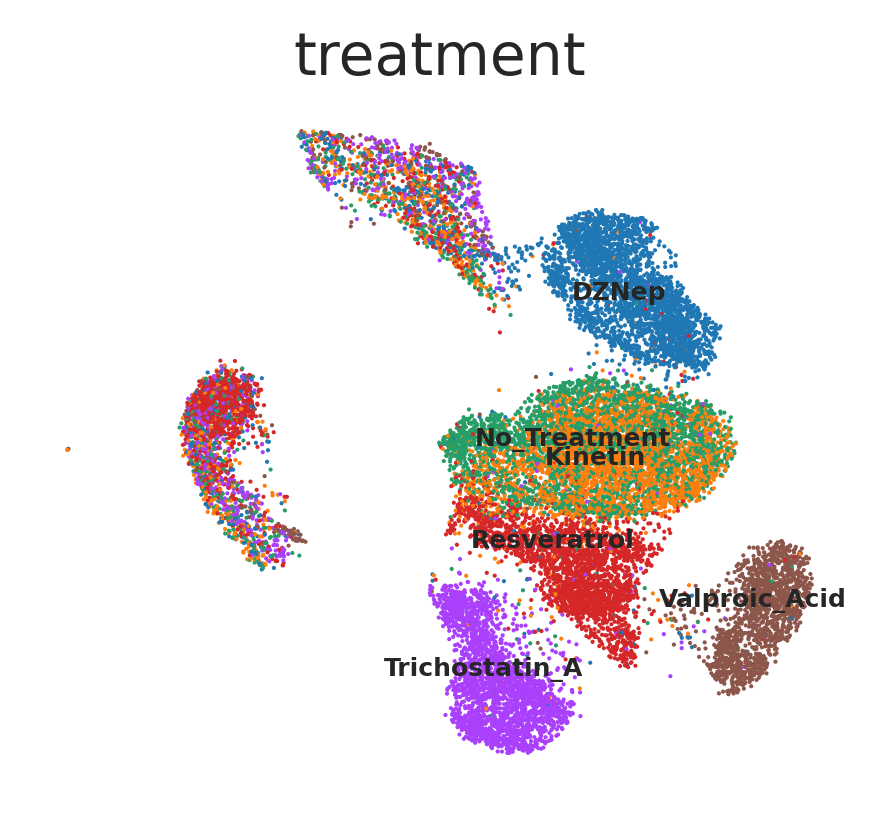

In [14]:
sc.settings.set_figure_params(dpi=150,figsize=(3.5, 3))

sc.pl.umap(adata_out, size=4, color=["treatment"],
           frameon=False,
           legend_loc="on data", legend_fontsize=6,
           )

Cells assigned with a same treatment (e.g. DZNep, Trichostatin A, Valproic Acid, or Resveratrol) present similar transcriptomic profile.